# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [60]:
import pandas as pd
pd.set_option('display.max_rows', 500)
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import pylab as pl

%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20
#used to change matplotlib styling
#changing font size
#Follow PEP8 guidelines


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
#grbAG = pd.read_csv('grb050525A.txt')
#grbAG.head()
#grbAG["logtime"] = np.log10(grbAG['time'])
#grbAG.head()
#grbAG.loc[grbAG["filter"] == "V", "mag"]
#print(grbAG.loc[[117]])

# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

find the link to the *raw* input file on github in the HW1 folder https://github.com/fedhere/MLTSA_FBianco/tree/master/HW1

In [62]:
url1 = "https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A_all.dat"
grball = pd.read_csv(url1, sep = ' ', header = None, 
                     names = ["filter", "time", "exposure", "mag", "magerr", "flux", "fluxerr", "None"],index_col=None)
grball.head()

,filter,time,exposure,mag,magerr,flux,fluxerr,None
0,V,66,1.0,13.21,0.24,189.8,41.2,NaN
1,V,67,1.0,12.90,0.23,254.0,53.6,NaN
2,V,68,1.0,12.86,0.23,263.3,55.5,NaN
3,V,69,1.0,13.01,0.23,227.9,48.5,NaN
4,V,70,1.0,12.97,0.23,236.3,50.1,NaN


In [63]:
url2 = "https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv"
grbtxt = pd.read_csv(url2)
grbtxt.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space. (Note: we mean logbase 10, use ```numpy.log10()```


In [64]:
grbtxt['logtime'] = np.log10(grbtxt['time'])
grbtxt.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. If I wanted to retrieve all magnitudes for filter 'V' I would do ```grbAG.loc[grbAG["filter"] == f, "mag"]```.

Plot the data with different colors for different photometric bands. 

In [0]:
Varray = grbtxt.loc[grbtxt['filter']=="V",'mag']
M2array = grbtxt.loc[grbtxt['filter']=="M2",'mag']
W1array = grbtxt.loc[grbtxt['filter']=="W1",'mag']
Uarray = grbtxt.loc[grbtxt['filter']=="U",'mag']
Barray = grbtxt.loc[grbtxt['filter']=="B",'mag']

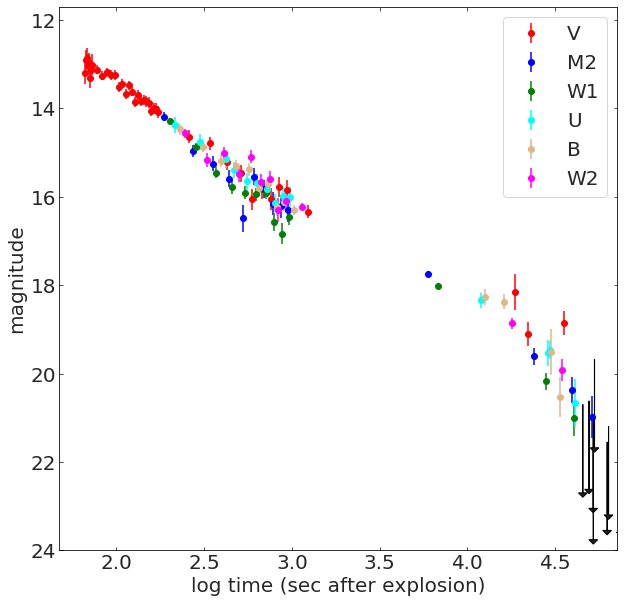

In [66]:
#this code is so much smarter than mine dang
#f designates color. I.e. "V", "W1",etc
#Create array of mags, array of logtimes, plot with time as x axis

ax = pl.figure(figsize=(10,10)).add_subplot(111)
#will cycle through clrs in clrs
clrcount = 0
#list of clrs I want to use
clrs = ['red','blue','green','cyan','burlywood','magenta']
for f in grbtxt["filter"].unique():
    mags = grbtxt.loc[grbtxt['filter']==f,'mag']
    logt = grbtxt.loc[grbtxt['filter']==f,'logtime']
    error = grbtxt.loc[grbtxt['filter']==f,'magerr']
    #pl.scatter(logt,mags)
    pl.errorbar(logt,mags,yerr = error,fmt='o',color=clrs[clrcount],label = f)
    clrcount += 1

#upperlimit == 1 is for last elements of the data array. They have missing magnitudes   
#.loc[i] pulls up data for that index
#arrow works from x,y to dx,dy. so dx = 0, dy = 2.
for i in grbtxt[grbtxt.upperlimit==1].index:
    pl.arrow(grbtxt.loc[i].logtime, 
             grbtxt.loc[i].magerr,
             0, 2, head_width = 0.05, head_length = 0.1, ec = 'k')
    
pl.ylim(24,11.7)          
pl.legend()

pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

#taken from the test notebook

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. Time is relative from the estimated moment of explosion of the stellar progenitor.
##

Different filters are represented by different colored points. Logtime vs. magnitude. Upperlimits are shown with black arrow. 

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [0]:
x = grbtxt[grbtxt.upperlimit==0].logtime.values
#thats so clever! we want the array to be the length of the elements with upper limit 0, so subtract
#all the sum of the elements with 1 (all the sum actually. = 11). The last 1 is the number of columns to make
X = np.c_[np.ones((len(grbtxt)-grbtxt.upperlimit.sum(),1)),x]
y = grbtxt[grbtxt.upperlimit==0].mag.values

#X = np.c_[np.ones((len(grbtxt)-grbtxt.upperlimit.sum(),2)),x]
#X
#c_?

In [68]:
print(X.shape)
print(y.shape)

#This is the X^T * X ... equation. who knew?
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(theta_best)

(108, 2)
(108,)
[8.58266823 2.51199984]


In [69]:
#format limits the number of digits
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 
To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```



In [70]:
#minimize the residual sum of squares between the observed targets in the dataset, 
#and the targets predicted by the linear approximation
linreg = LinearRegression()
linreg.fit(X,y)
#coefficient is slope
print ("best fit parameters from the sklearn LinearRegression() (L1): " + 
       "intercept {:.2f}, slope {:.2f}".format(linreg.intercept_, linreg.coef_[1]))

best fit parameters from the sklearn LinearRegression() (L1): intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [71]:
##L1
def line(x,intercept,slope):
    return slope*x + intercept


def l1(args, x, y):
    a, b = args
    return sum(np.abs((y - line(x, a, b))))
initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. 
#But for this simple problem we can just guess whaetever

initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. 
#But for this simple problem we can just guess whaetever

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.303314676736687
 hess_inv: array([[ 2.28729739e-04, -1.05009451e-04],
       [-1.05009451e-04,  4.82205861e-05]])
      jac: array([-2.        , -5.67277241])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 465
      nit: 18
     njev: 114
   status: 2
  success: False
        x: array([8.22523567, 2.64075721])

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [72]:
##Chi-Squared
def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(x, a, b))**2 / s)
initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. 
#But for this simple problem we can just guess whaetever

s = grbtxt[grbtxt.upperlimit==0].magerr.values
chi2Solution = minimize(chi2, initialGuess, args=(x, y,s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 58.49837428948374
 hess_inv: array([[ 0.01113153, -0.00381294],
       [-0.00381294,  0.00139784]])
      jac: array([-4.76837158e-07,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([8.58159553, 2.49968626])

best fit parameters from the minimization of L1: slope 8.58, intercept 2.50


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


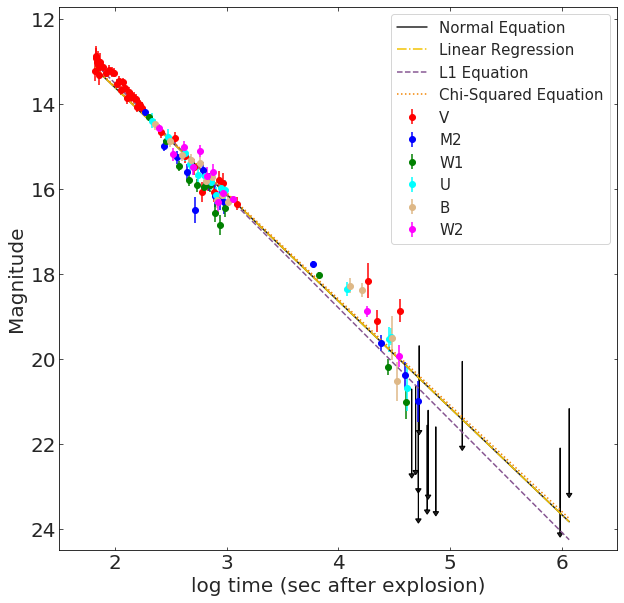

In [73]:
logt = grbtxt.logtime.values
linestyles = ['-', '--', '-.', ':']
def plotline(slope, intercept,label,style):
    y0 = slope*logt + intercept
    #y1 = linreg.coef_[1]*x + linreg.intercept_
    #y2 = theta_best[1]*x + theta_best[0]
    pl.plot(logt,y0,label=label,linestyle = style)
    #pl.plot(logt,y2)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

# plot the datapoints as above as errorbars
# plot the upperlimits as arrows (see above)

#plot the models

#normal equation
plotline(theta_best[1],theta_best[0],"Normal Equation",'-')
         
#sklearn
plotline(linreg.coef_[1],linreg.intercept_,"Linear Regression",'-.')
         
#minimize L1
plotline(l1Solution.x[1],l1Solution.x[0],"L1 Equation",'--')
         
#minimize chi2
plotline(chi2Solution.x[1],chi2Solution.x[0],"Chi-Squared Equation",':')

clrcount = 0
#list of clrs I want to use
clrs = ['red','blue','green','cyan','burlywood','magenta']
for f in grbtxt["filter"].unique():
    mags = grbtxt.loc[grbtxt['filter']==f,'mag']
    logt = grbtxt.loc[grbtxt['filter']==f,'logtime']
    error = grbtxt.loc[grbtxt['filter']==f,'magerr']
    #pl.scatter(logt,mags)
    pl.errorbar(logt,mags,yerr = error,fmt='o',color=clrs[clrcount],label = f)
    clrcount += 1

#upperlimit == 1 is for last elements of the data array. They have missing magnitudes   
#.loc[i] pulls up data for that index
#arrow works from x,y to dx,dy. so dx = 0, dy = 2.
for i in grbtxt[grbtxt.upperlimit==1].index:
    pl.arrow(grbtxt.loc[i].logtime, 
             grbtxt.loc[i].magerr,
             0, 2, head_width = 0.05, head_length = 0.1, ec = 'k')
    
    

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)       
pl.legend(prop={'size': 15})


pl.ylabel("Magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1 with points marked according to filter, but now with best fit lines drawn through. Different methods of finding best fit line are shown in different line styles. Modles were used on data without upper limits. Finding the line through solving the Normal equation and using sklearn's linear regression produced the same results. 

# Create a table with the results of each method
(see here for table syntax in markdown) https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables

|method | slope | intercept |
|- | -| -|


Method | Slope | Intercept
--- | --- | ---
Normal Equation |  2.51  |  8.58
Linear Regression |  2.51 |  8.58
L1 |  2.64 |  8.23
Chi-Squared |  2.5 |  8.58
